In [778]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.4f' % x)
import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')
import warnings
warnings.filterwarnings('ignore')
from time import time
import matplotlib.ticker as tkr
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from sklearn import preprocessing
from statsmodels.tsa.stattools import pacf
%matplotlib inline
import math
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping

In [779]:
import pandas as pd
#%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
from scipy import stats
from datetime import datetime
from pylab import rcParams
import statsmodels.api as sm
import itertools
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [780]:
#Reading dataset
dataset = pd.read_csv('salesdaily_pharma_datatoread.csv')
dataset

,datum,M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06,Total sales,Year,Month,Hour,Weekday Name
0,1/2/2014,0.0000,3.6700,3.4000,32.4000,7.0000,0.0000,0.0000,2.0000,48.4700,2014,1,248,Thursday
1,1/3/2014,8.0000,4.0000,4.4000,50.6000,16.0000,0.0000,20.0000,4.0000,107.0000,2014,1,276,Friday
2,1/4/2014,2.0000,1.0000,6.5000,61.8500,10.0000,0.0000,9.0000,1.0000,91.3500,2014,1,276,Saturday
3,1/5/2014,4.0000,3.0000,7.0000,41.1000,8.0000,0.0000,3.0000,0.0000,66.1000,2014,1,276,Sunday
4,1/6/2014,5.0000,1.0000,4.5000,21.7000,16.0000,2.0000,6.0000,2.0000,58.2000,2014,1,276,Monday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2101,10/4/2019,7.3400,5.6830,2.2500,22.4500,13.0000,0.0000,1.0000,1.0000,52.7230,2019,10,276,Friday
2102,10/5/2019,3.8400,5.0100,6.0000,25.4000,7.0000,0.0000,0.0000,0.3300,47.5800,2019,10,276,Saturday
2103,10/6/2019,4.0000,11.6900,2.0000,34.6000,6.0000,0.0000,5.0000,4.2000,67.4900,2019,10,276,Sunday
2104,10/7/2019,7.3400,4.5070,3.0000,50.8000,6.0000,0.0000,10.0000,1.0000,82.6470,2019,10,276,Monday


In [781]:
#DATA PREPROCESSING 
#convert string Date time into Python Date time object
dataset['datum'] = pd.to_datetime(dataset['datum'])
#removing unwanted columns
to_drop = ['M01AB', 'M01AE', 'N02BA', 'N02BE', 'N05B', 'N05C', 'R03', 'R06', 'Year', 'Month', 'Hour', 'Weekday Name'] #removing unwanted columns
dataset.drop(columns=to_drop, inplace=True)
print(dataset.info()) # to check for empty values
dataset = dataset.groupby('datum')['Total sales'].sum().reset_index()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2106 entries, 0 to 2105
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   datum        2106 non-null   datetime64[ns]
 1   Total sales  2106 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 33.0 KB
None


In [782]:
#Indexing with Time Series Data
dataset = dataset.set_index('datum')
dataset.index

DatetimeIndex(['2014-01-02', '2014-01-03', '2014-01-04', '2014-01-05',
               '2014-01-06', '2014-01-07', '2014-01-08', '2014-01-09',
               '2014-01-10', '2014-01-11',
               ...
               '2019-09-29', '2019-09-30', '2019-10-01', '2019-10-02',
               '2019-10-03', '2019-10-04', '2019-10-05', '2019-10-06',
               '2019-10-07', '2019-10-08'],
              dtype='datetime64[ns]', name='datum', length=2106, freq=None)

In [749]:
#Removing outliers
Highest_tsales = (df['Total sales'].max())
print (Highest_tsales)
df = df[(df["Total sales"] <198.95) & (df["Total sales"]> 0)]
df

198.95


,datum,Total sales
0,2014-01-02,48.4700
1,2014-01-03,107.0000
2,2014-01-04,91.3500
3,2014-01-05,66.1000
4,2014-01-06,58.2000
...,...,...
2101,2019-10-04,52.7230
2102,2019-10-05,47.5800
2103,2019-10-06,67.4900
2104,2019-10-07,82.6470


In [783]:
#Removing outliers using interquartile range 
Q1 = df["Total sales"].quantile(0.25) #calculating quantiles to know what are the outliers
print (Q1)
Q3 = df["Total sales"].quantile(0.75)
print (Q3)
IQR = Q3 - Q1
lower =  Q1 - 1.5 * IQR # the lower and upper bounds for data based on outliers
upper = Q3 + 1.5 * IQR
df = df[(df["Total sales"] < upper) & (df["Total sales"]> lower)]

46.7075
72.17


In [784]:
#setting format according to date-time and sorting based on datum column
df.sort_values('datum', inplace=True, ascending=True)
df = df.reset_index(drop=True)
df.index = pd.to_datetime(df.index, origin=pd.Timestamp('2014-01-02'), unit='D')
df 

,datum,Total sales
2014-01-02,2014-01-02,48.4700
2014-01-03,2014-01-03,107.0000
2014-01-04,2014-01-04,91.3500
2014-01-05,2014-01-05,66.1000
2014-01-06,2014-01-06,58.2000
...,...,...
2019-07-29,2019-10-04,52.7230
2019-07-30,2019-10-05,47.5800
2019-07-31,2019-10-06,67.4900
2019-08-01,2019-10-07,82.6470


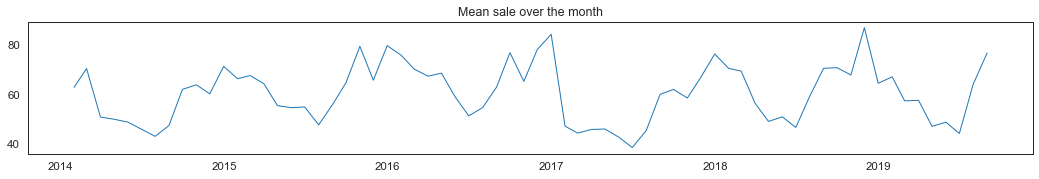

In [785]:
#Resampling based on mean per day
fig = plt.figure(figsize=(18,16))
fig.subplots_adjust(hspace=.4)
ax1 = fig.add_subplot(5,1,1)
ax1.plot(df.resample('M').mean(),linewidth=1)
ax1.set_title('Mean sale over the month')
ax1.tick_params(axis='both', which='major')

In [786]:
#Testing if data is normal
stat, p = stats.normaltest(df['Total sales'])
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('Data looks Gaussian (fail to reject H0)')
else:
    print('Data does not look Gaussian (reject H0)')

Statistics=60.293, p=0.000
Data does not look Gaussian (reject H0)


df

In [787]:
#Checking stationarity 
df2 = df.resample('W').mean()

def test_stationarity(timeseries):
    rolmean = timeseries.rolling(window=30).mean()
    rolstd = timeseries.rolling(window=30).std()
    
    plt.figure(figsize=(14,5))
    sns.despine(left=True)
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')

    plt.legend(loc='best'); plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    print ('<Results of Dickey-Fuller Test>')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4],
                         index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

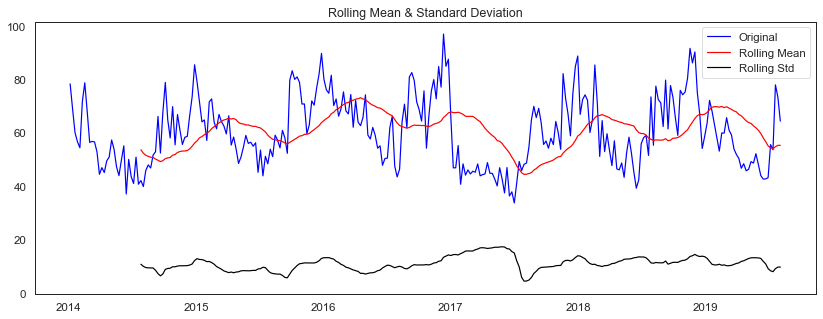

<Results of Dickey-Fuller Test>
Test Statistic                 -3.5618
p-value                         0.0065
#Lags Used                      8.0000
Number of Observations Used   283.0000
Critical Value (1%)            -3.4537
Critical Value (5%)            -2.8718
Critical Value (10%)           -2.5722
dtype: float64
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 292 entries, 2014-01-05 to 2019-08-04
Freq: W-SUN
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Total sales  292 non-null    float64
dtypes: float64(1)
memory usage: 4.6 KB
None


In [788]:
test_stationarity(df2)
#p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.
print(df2.info())

In [789]:
dataset = df2.to_numpy() #numpy.ndarray
dataset = dataset.astype('float32')
dataset = np.reshape(dataset, (-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
train_size = int(len(dataset) * 0.60)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [790]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

In [791]:
# reshape into X=t and Y=t+1
look_back = 30
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

In [792]:
X_train.shape

(144, 30)

In [793]:
Y_train.shape

(144,)

In [794]:
# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [795]:
X_train.shape

(144, 1, 30)

In [796]:
model = Sequential()
model.add(LSTM(20, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train, Y_train, epochs=20, batch_size=20, validation_data=(X_test, Y_test), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=1, shuffle=False)

# Training Phase
model.summary()

Train on 144 samples, validate on 86 samples
Epoch 1/20
144/144 [==============================] - 3s 23ms/step - loss: 0.0735 - val_loss: 0.0387
Epoch 2/20
144/144 [==============================] - 0s 238us/step - loss: 0.0434 - val_loss: 0.0369
Epoch 3/20
144/144 [==============================] - 0s 233us/step - loss: 0.0400 - val_loss: 0.0342
Epoch 4/20
144/144 [==============================] - 0s 235us/step - loss: 0.0368 - val_loss: 0.0313
Epoch 5/20
144/144 [==============================] - 0s 241us/step - loss: 0.0338 - val_loss: 0.0298
Epoch 6/20
144/144 [==============================] - 0s 225us/step - loss: 0.0302 - val_loss: 0.0283
Epoch 7/20
144/144 [==============================] - 0s 235us/step - loss: 0.0320 - val_loss: 0.0271
Epoch 8/20
144/144 [==============================] - 0s 211us/step - loss: 0.0324 - val_loss: 0.0259
Epoch 9/20
144/144 [==============================] - 0s 265us/step - loss: 0.0260 - val_loss: 0.0250
Epoch 10/20
144/144 [=================

In [797]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# invert predictions
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])

print('Train Mean Absolute Error:', mean_absolute_error(Y_train[0], train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test[0], test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))


Train Mean Absolute Error: 6.134012287640114
Train Root Mean Squared Error: 8.306209387877303
Test Mean Absolute Error: 7.177680582464323
Test Root Mean Squared Error: 9.06262563497665


In [798]:
Y_test.shape

(1, 86)

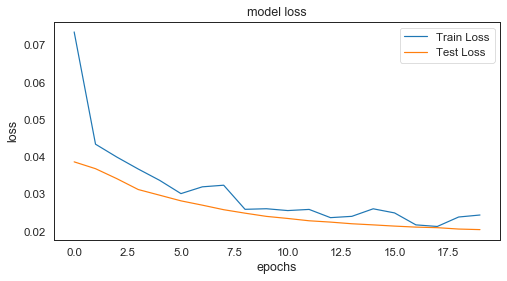

In [799]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

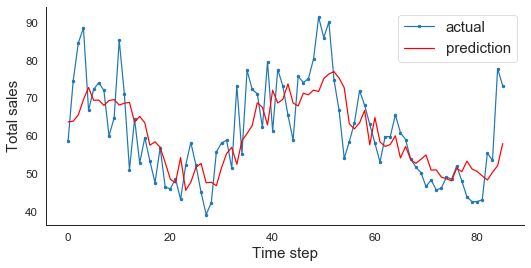

In [800]:
aa=[x for x in range(86)]
plt.figure(figsize=(8,4))
plt.plot(aa, Y_test[0][:86], marker='.', label="actual")
plt.plot(aa, test_predict[:,0][:86], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
# plt.tick_params(left=False, labelleft=True) #remove ticks
#plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Total sales', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();